In [1]:
import json
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

from transformers import BartTokenizer

In [2]:
PATH = json.load(open('path_config.json'))

#### Read XSum

In [3]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [4]:
from tqdm import tqdm

In [5]:
data = json.load(open('annotated_with_probability.json', 'r'))
print(len(data))

118


In [6]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'xsum_cmlm_bos': 0.02984619140625,
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_scratch_cedar_warmup_10000': 0.190185546875,
   'cnndm_cmlm_scratch_cedar_warmup_20000': 3.2782554626464844e-06,
   'bart.large.xsum': 0.0200347900390625},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'xsum_cmlm_bos': 0.0843505859375,
   'bart.large': 0.05804443359375,
   'xsum_cmlm_scratch_cedar_warmup_10000': 0.00960540771484375,
   'cnndm_cmlm_scratch_cedar_warmup_20000': 1.6808509826660156e-05,
   'bart.large.xsum': 0.06317138671875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent'

In [7]:
# with open('annotated_with_probability.json', 'w') as fout:
#     json.dump(data , fout)

#### Prior/Posterior Distribution Diagram

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

In [9]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

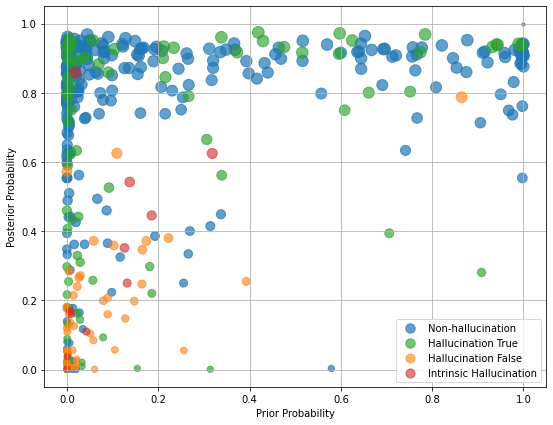

In [10]:
fig, ax = plt.subplots(figsize=(9.0, 7.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [11]:
# for p in prior_posterior:
#     if p['prior'] > 0.9:
#         print(p)

#### Baseline Model

In [12]:
from sklearn.metrics import classification_report

In [13]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'cnndm_cmlm_cedar': 0.80859375,
 'xsum_cmlm_bos': 0.019073486328125,
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_scratch_cedar_warmup_10000': 0.00994110107421875,
 'cnndm_cmlm_scratch_cedar_warmup_20000': 0.0027942657470703125,
 'bart.large.xsum': 0.0927734375,
 'id': 8805,
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125}

In [14]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [15]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [16]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3551    0.9800    0.5213        50
     Factual     0.9961    0.7435    0.8515       347

    accuracy                         0.7733       397
   macro avg     0.6756    0.8618    0.6864       397
weighted avg     0.9154    0.7733    0.8099       397



In [17]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8986    0.9764    0.9358       127
    Hallucinated     0.9884    0.9481    0.9679       270

        accuracy                         0.9572       397
       macro avg     0.9435    0.9623    0.9519       397
    weighted avg     0.9597    0.9572    0.9576       397



In [18]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1636    0.1800    0.1714        50
     Factual     0.8801    0.8674    0.8737       347

    accuracy                         0.7809       397
   macro avg     0.5219    0.5237    0.5226       397
weighted avg     0.7899    0.7809    0.7853       397



In [19]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.3455    0.1496    0.2088       127
    Hallucinated     0.6842    0.8667    0.7647       270

        accuracy                         0.6373       397
       macro avg     0.5148    0.5081    0.4867       397
    weighted avg     0.5758    0.6373    0.5869       397



### KNN

In [20]:
import numpy as np
import matplotlib

from sklearn.manifold import TSNE
from sklearn import neighbors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [21]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [22]:
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=12)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6602    0.5354    0.5913       127
Non-hallucinated     0.7993    0.8704    0.8333       270

        accuracy                         0.7632       397
       macro avg     0.7298    0.7029    0.7123       397
    weighted avg     0.7548    0.7632    0.7559       397



In [23]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, factual_label, n_neighbors=10)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.3929    0.4400    0.4151        50
     Factual     0.9179    0.9020    0.9099       347

    accuracy                         0.8438       397
   macro avg     0.6554    0.6710    0.6625       397
weighted avg     0.8518    0.8438    0.8476       397



In [24]:
def plot(taskname, HJ, model_probs, labels, n_neighbors=15, fig_size=(4.5, 3.5), 
         colors=['red', 'blue'], legend_labels=['Factual', 'Non-factual']):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
    x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat,y_vec)
    
    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = x_mat[:, 0].min() - .5, x_mat[:, 0].max() + .5
    y_min, y_max = x_mat[:, 1].min() - .5, x_mat[:, 1].max() + .5
    
    h = 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, h) * np.std(pin),
                             np.arange(y_min, y_max, h) * np.std(HJ))
    
    # Plot color map
    cm = plt.cm.RdBu
    fig, ax = plt.subplots(figsize=fig_size)
    ax.contourf(xx_1, yy_1, Z, cmap=cm, alpha=.7)
    
    ax.scatter(np.array(pin)[np.nonzero(larray==1)[0]], np.array(HJ)[np.nonzero(larray==1)[0]], 
               color=colors[1], edgecolor='black', label=legend_labels[1], alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==0)[0]], np.array(HJ)[np.nonzero(larray==0)[0]], 
               color=colors[0], edgecolor='black', label=legend_labels[0], marker='s', alpha=0.8)

    
    # Plot Hist diagram
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 0.7, pad=0.0, sharex=ax)
    axHisty = divider.append_axes("right", 0.7, pad=0.0, sharey=ax)
    axHistx.xaxis.set_tick_params(labelbottom=False, bottom=False)
    axHistx.yaxis.set_tick_params(labelleft=False, left=False)
    axHisty.xaxis.set_tick_params(labelbottom=False, bottom=False)
    axHisty.yaxis.set_tick_params(labelleft=False, left=False)
    b_subset = np.nonzero(larray==1)[0]
    r_subset = np.nonzero(larray==0)[0]
    x = np.array(pin)
    y = np.array(HJ)
    _ = axHistx.hist(x[b_subset], color=colors[1], bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
    _ = axHistx.hist(x[r_subset], color=colors[0], bins=np.arange(x_min, x_max, 0.3)*np.std(pin), alpha=0.7)
    _ = axHisty.hist(y[b_subset], color=colors[1], bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)
    _ = axHisty.hist(y[r_subset], color=colors[0], bins=np.arange(y_min, y_max, 0.3)*np.std(HJ), orientation='horizontal', alpha=0.7)

    ax.legend(loc='lower right')
    ax.set_xlim(np.min(xx_1), np.max(xx_1))
    ax.set_ylim(np.min(yy_1), np.max(yy_1))
    ax.set_xlabel('Prior Probability', fontweight ='bold', fontsize=11)
    ax.set_ylabel('Posterior Probability', fontweight ='bold', fontsize=11)
#     axHistx.set_title(taskname)
    plt.tight_layout()
    plt.savefig("figures/" + taskname +'.pdf')
    plt.show()

In [25]:
def plot_three(taskname, HJ, model_probs, labels, n_neighbors=15, 
               fig_size=(4.5, 3.5), colors=['green', 'blue', 'red'], legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion']):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
    x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat,y_vec)
    
    # Plot the decision boundary. For that, we will asign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
#     x_min, x_max = x_mat[:, 0].min() - .5, x_mat[:, 0].max() + .5
#     y_min, y_max = x_mat[:, 1].min() - .5, x_mat[:, 1].max() + .5
    
#     h = 0.05
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
#     Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#     Z = Z.reshape(xx.shape)
    
#     xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, h) * np.std(pin),
#                              np.arange(y_min, y_max, h) * np.std(HJ))
    
    # Plot color map
    cm = plt.cm.RdBu
    fig, ax = plt.subplots(figsize=fig_size)
#     ax.contourf(xx_1, yy_1, Z, cmap=cm, alpha=.7)

    ax.scatter(np.array(pin)[np.nonzero(larray==0)[0]], np.array(HJ)[np.nonzero(larray==0)[0]], color=colors[0], 
               edgecolor='black', label=legend_labels[0], marker='s', alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==1)[0]], np.array(HJ)[np.nonzero(larray==1)[0]], color=colors[1], 
               edgecolor='black', label=legend_labels[1], alpha=0.8)
    ax.scatter(np.array(pin)[np.nonzero(larray==2)[0]], np.array(HJ)[np.nonzero(larray==2)[0]], color=colors[2], 
               edgecolor='black', label=legend_labels[2], alpha=0.8)
    
    ax.legend(loc='lower right')
#     ax.set_xlim(np.min(xx_1), np.max(xx_1))
#     ax.set_ylim(np.min(yy_1), np.max(yy_1))
    ax.set_xlabel('CMLM trained on CNN/DM from scratch', fontweight ='bold', fontsize=11)
    ax.set_ylabel('CMLM trained on XSum from scratch', fontweight ='bold', fontsize=11)
#     axHistx.set_title(taskname)
    plt.tight_layout()
    plt.savefig("figures/" + taskname +'.pdf')
    plt.show()

In [26]:
font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

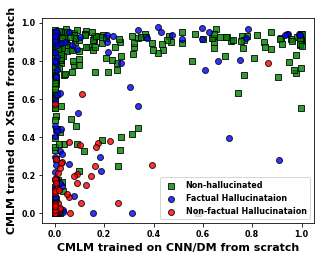

In [27]:
plot_three('entity_distribution_2scratch', posterior_probabilities, prior_probabilities, true_label, 
     n_neighbors=10, fig_size=(4.5, 3.5))

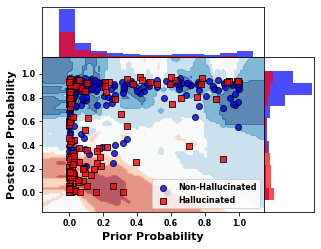

In [28]:
plot('Hallucination Entity Classification', posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'])

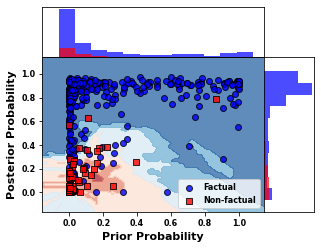

In [29]:
plot('compare_mlm_and_cmlm', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'])

#### Save KNN Model

In [30]:
import pickle

In [31]:
def build_KNN(HJ, model_probs, labels, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    larray = np.array(labels)
    HJ = np.array(HJ)
    nmodel_probs = np.array(model_probs)
    
    pin = nmodel_probs
#     x_mat = np.vstack([pin / np.std(pin), HJ / np.std(HJ)]).transpose()
    x_mat = np.vstack([pin, HJ]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [32]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, hallucination_label_reverse, n_neighbors=3)

In [33]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities]).transpose()))

In [34]:
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.3929    0.4400    0.4151        50
     Factual     0.9179    0.9020    0.9099       347

    accuracy                         0.8438       397
   macro avg     0.6554    0.6710    0.6625       397
weighted avg     0.8518    0.8438    0.8476       397



In [35]:
# # source, destination
pickle.dump(knn_classifier, open('classifiers/knn_correct_cmlm_cmlm.pkl', 'wb') )

#### AUC

In [36]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [37]:
p1, p2, p3, p4, p5, p6 = [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['cnndm_cmlm_cedar'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_10000'])
        p4.append(p['bart.large'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_20000'])
        p6.append(p['bart.large.xsum'])

assert len(p1) == len(factual_label)

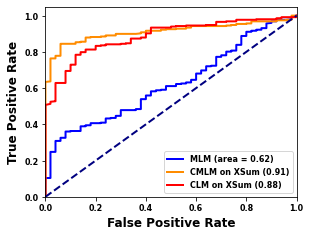

In [38]:
plt.figure(figsize=(4.5, 3.5))
lw = 2

# posterior
fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p4))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue',
         lw=lw, label='MLM (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p2))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='CMLM on XSum (%0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p6))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red',
         lw=lw, label='CLM on XSum (%0.2f)' % roc_auc)

# # posterior
# fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p1))
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, color='green',
#          lw=lw, label='CMLM on CNN/DM (%0.2f)' % roc_auc)

# # posterior
# fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p3))
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, color='red',
#          lw=lw, label='CMLM on XSum from scratch (%0.2f)' % roc_auc)

# # posterior
# fpr, tpr, _ = roc_curve(np.asarray(factual_label), np.asarray(p5))
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, color='aqua',
#          lw=lw, label='CMLM on CNN/DM from scratch (%0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight ='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight ='bold', fontsize=12)
# plt.title('ROC Curve ')
plt.legend(loc="lower right")
plt.savefig('figures/auc_clm_cmlm.pdf')
plt.show()